# <u>Формулировка задачи<u>
---
**Предлагается разобраться в содержании работы ‘Color Correction Using Root-Polynomial Regression’ Finlayson et al. doi:10.1109/tip.2015.2405336**

**<u>Вопросы:<u>**
1. Зачем решать задачу перехода из пространства камеры в пространство стандартного наблюдателя? Почему это различные пространства?
    * все цветовые пространства строятся на основе пространства стандартного наблюдателя
    * у каждой камеры своё цветовое пространство
    * Значения R, G, B для каждой камеры могут быть непонятно какими, поэтому из пространства камеры изображение необходимо переводить в стандартизированное пространство CIE XYZ, чтобы полученное камерой изображение можно было воспроизводить на различных устройствах
2. В чем основная сложность задачи перехода из одного цветового пространства в другое? Что такое метамеризм? Что такое условие Лютера?
    * **Метамеризм** - являние того, что несколько разных спектров могут иметь один цвет
    * **Критерий Лютера-Айвса** - для возможности колориметрически точной регистрации цвета трёхкомпонентной системой фотодетекторов необходимо и достаточно, чтобы спектральные чувствительности её фотодетекторов r(l), g(l) и b(l) были линейными комбинациями спектральных чувствительностей колбочек стандартного наблюдателя. Из-за этого условия в общем значения в пространстве стандартного наблюдателя линейно не выразимы через значения в пространстве камеры
3. В чем заключаются недостатки LCC и PCC?
    * LCC - модель, не зависящая от экспозиции, но предсказывающая довольно неточно из-за того, что подгоняет значения, перебирая только линейные комбинации R, G, B. Но значения X, Y, Z в общем случае линейно не выразимы через R, G, B
    * PCC - усовершенствованная модель LCC, дополненная полиномиальным расширением признаков, чтобы более точно предсказывать значения X, Y, Z. Однако модель зависит от экспозиции - если масштабировать значения R, G, B на k, то, на примере PCC 2 степени, признаки, полученные полиномиальным расширением, будут масштабироваться на k или $k^2$
4. В чем состоит идея нового метода color correction?
    * RPCC - метод, который совмещает в себе преимущества PCC над LCC (присутствует полиномиальное расширение), а также НЕ зависит от экспозиции, благодаря взятию корня n степени из признака n степени. Таким образом, масштабируя значения R, G, B на k, все признаки также масштабируются на k.
5. Подсчитать суммарное число признаков для полиномиальной коррекции (PCC) степени k  
    * количество членов k степени - сочетание из 3 по k  с повторениями, то есть $C_{n+k-1}^k$
    * $h = \sum_{i=1}^k C_{n+i-1}^i = C_{n+k}^{k} - 1 = C_{n+k}^n - 1$,\
    где n = 3 (R, G, B),\
    k - степень PCC
    
**<u>Будет преимуществом, если студент продемонстрирует работу RPCC. Предлагается следующий набор задач:<u>**
1. Смоделировать колорчекер в пространстве камеры и в пространстве CIE XYZ
2. Обучить по схеме leave-one-out и оценить качество RPCC по угловой метрике

**<u>Демонстрация работы RPCC на гиперспектральных данных датасета Ли**
1. (*) Сгенерировать гиперспектральное изображение в пространстве камеры и в пространстве CIE XYZ (контрольный вопрос - что такое гиперспектральное изображение?)
2. (*) Применить модель к сгенерированному в пространстве камеры изображению
3. (*) Посчитать угловую ошибку между сгенерированным в CIE XYZ и преобразованным моделью изображениями

    
**<u>Используемые файлы<u>**: 
* файл с чувствительностями canon 600D
* файл с чувствительностями стандартного наблюдателя
* данные для колорчекера 
* 2 изображения, взятых из датасета Ли. https://repository.kaust.edu.sa/handle/10754/670368


# <u>Выполнение задачи<u>

# l. <u>Исследование работы предложенного алгоритма RPCC на колорчекере<u>

># 0. Импорты

In [1]:
import colour
from colour.algebra import least_square_mapping_MoorePenrose

import numpy as np
import h5py
import scipy.io
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict

sns.set(style='whitegrid', font_scale=1.2, palette='Set2')
%matplotlib inline

> ## 1. Моделирование колорчекера в XYZ и в пространстве камеры

Файл с чувствительностями стандартного наблюдателя: **sensetivities/CIE 1964.csv**

Файл с чувствительностями камеры: **sensetivities/Canon 600D.csv**


**Считывание чувствительностей**

In [2]:
def get_cmfs():
    standard_oberver_df = pd.read_csv('/home/yaroslav/progs/iitp/root_polynomial_color_correction/sensetivities/CIE 1964.csv')
    canon_600d_df = pd.read_csv('/home/yaroslav/progs/iitp/root_polynomial_color_correction/sensetivities/Canon 600D.csv')

    canon_600d_data = {}
    [canon_600d_data.update(i) for i in list(canon_600d_df.apply(lambda x:{x.wavelength:(x.r, x.g, x.b)}, axis=1))]

    observer_data = {}
    [observer_data.update(i) for i in list(standard_oberver_df.apply(lambda x:{x.wavelength:(x.x_bar, x.y_bar, x.z_bar)}, axis=1))]

    cmfs_camera = colour.MultiSpectralDistributions(canon_600d_df.set_index('wavelength'))
    cmfs_cie = colour.MultiSpectralDistributions(standard_oberver_df.set_index('wavelength'))
    return (cmfs_camera, cmfs_cie)
cmfs_camera, cmfs_cie = get_cmfs()
illuminant = colour.SDS_ILLUMINANTS["D65"]

**Получение спектра колорчекера**

In [3]:
checker_spectrum = colour.SDS_COLOURCHECKERS['BabelColor Average']
colours = list(dict(colour.SDS_COLOURCHECKERS['BabelColor Average']).keys())

**Преобразование спектра колорчекера в XYZ и в пространство камеры**

In [4]:
checker_camera = np.array([list(colour.sd_to_XYZ(checker_spectrum[i], cmfs=cmfs_camera, illuminant=illuminant, 
                                method='Integration')) for i in colours])
checker_XYZ = np.array([list(colour.sd_to_XYZ(checker_spectrum[i], cmfs=cmfs_cie, illuminant=illuminant, 
                                method='Integration')) for i in colours])
shape = colour.SpectralShape(380, 730, 10)

> # 2. Обучение модели RPCC (аналитическое решение)
> # по схеме leave-one-out 

**Создание класса модели**

In [5]:
class RPCC:
    def __init__(self, degree):
        self.degree = degree
    def fit(self, X, y):
        checker_camera_expansion = colour.characterisation.polynomial_expansion_Finlayson2015(X, 
                                                           degree=self.degree, root_polynomial_expansion=True)
        self.lstsq = least_square_mapping_MoorePenrose(checker_camera_expansion, y)
    def predict(self, X):
        X_expansion = colour.characterisation.polynomial_expansion_Finlayson2015(X, 
                                                           degree=self.degree, root_polynomial_expansion=True)
        return np.reshape(np.transpose(np.dot(self.lstsq, np.transpose(X_expansion))), X.shape)
    def get_params(self, deep=True):
    # suppose this estimator has parameters "alpha" and "recursive"
        return {"degree": self.degree}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    @staticmethod
    def get_cosine_rmse(y_pred, y):
        cosine_metric = np.array([cosine_similarity(y_pred[i].reshape(1, 3), 
                y[i].reshape(1, 3))[0][0] for i in range(y.shape[0])])
        rmse_metric = (np.array([mean_squared_error(y_pred[i].reshape(1, 3), 
                        y[i].reshape(1, 3)) for i in range(y.shape[0])]))
        return (cosine_metric, rmse_metric)
    
    @staticmethod
    def RPCC_leave_one_out_all_degrees(X, y):
        loo = LeaveOneOut()
        cosine = {}
        rmse = {}
        for i in range(1, 5):
            model = RPCC(i)
            y_pred = cross_val_predict(model, X, y, cv=loo)
            cosine_metric = np.array([cosine_similarity(y_pred[i].reshape(1, 3), 
                y[i].reshape(1, 3))[0][0] for i in range(y.shape[0])])
            rmse_metric = (np.array([mean_squared_error(y_pred[i].reshape(1, 3), 
                            y[i].reshape(1, 3)) for i in range(y.shape[0])]))
            cosine.update({i:cosine_metric})
            rmse.update({i:rmse_metric})
        cosine = [(i, cosine[i]) for i in range(1, 5)]
        rmse = [(i, rmse[i]) for i in range(1, 5)]
        return (cosine, rmse)
    
    @staticmethod
    def visualise_cosine(cosine):
        sns.set(style='darkgrid', font_scale=1.2, palette='Set2')
        cosine_sim =  pd.concat([pd.DataFrame(np.hstack([cosine[i][1].reshape((-1, 1)), 
                        (i+1)*np.ones(cosine[i][1].shape[0]).reshape((-1, 1))])) for i in range(4)], axis=0)
        cosine_sim.columns = ['cosine', 'degree']
        cosine_sim.loc[:, 'degree'] = cosine_sim.degree.apply(lambda y: int(y))

        fig = plt.figure(figsize=(15, 12))
        ax = [fig.add_subplot(121), fig.add_subplot(122)]
        data = [cosine_sim.query('degree<4'), cosine_sim.query('degree==4')]
        
        for i in range(len(ax)):
            sns.boxplot(x='degree', y='cosine', data=data[i], hue='degree',
                        order=[1, 2, 3] if not i else [4],
                        palette='Set3', ax=ax[i], boxprops=dict(alpha=.3), dodge=False)
            ax[i].minorticks_on()
            ax[i].grid(which='major',
                    color = 'white',
                    linewidth = 3)
            ax[i].grid(which='minor',
                    color = 'white',
                    linewidth = 1)
            ax[i].legend(title='degree')

            ax[i].set_ylabel('cosine similarity pixel by pixel')
            ax[i].set_xlabel('degree')
        fig.suptitle('Boxplot of cosine similarity pixel by pixel')
        plt.plot()
        return (plt.gcf(), plt.gca())
    
    @staticmethod
    def visualise_rmse(rmse, ylims=None):
        sns.set(style='darkgrid', font_scale=1.2, palette='Set2')
        rmse_df =  pd.concat([pd.DataFrame(np.hstack([rmse[i][1].reshape((-1, 1)), 
                    (i+1)*np.ones(rmse[i][1].shape[0]).reshape((-1, 1))])) for i in range(4)], axis=0)
        rmse_df.columns = ['rmse', 'degree']
        rmse_df.loc[:, 'degree'] = rmse_df.degree.apply(lambda y: int(y))

        fig = plt.figure(figsize=(15, 12))
        ax = [fig.add_subplot(121), fig.add_subplot(122)]
        data = [rmse_df.query('degree<4'), rmse_df.query('degree==4')]
        
        for i in range(len(ax)):
            sns.boxplot(x='degree', y='rmse', data=data[i], hue='degree',
                        order=[1, 2, 3] if not i else [4],
                            palette='Set3', ax=ax[i], boxprops=dict(alpha=.3), dodge=False)
            ax[i].minorticks_on()
            ax[i].grid(which='major',
                    color = 'white',
                    linewidth = 3)
            ax[i].grid(which='minor',
                    color = 'white',
                    linewidth = 1)
            ax[i].legend(title='degree')
            ax[i].set_ylabel('RMSE pixel by pixel')
            ax[i].set_xlabel('degree')
            if ylims:
                ax[i].set_ylim(ylims[0] if not i else ylims[1])
            if i:
                ax[i].yaxis.set_major_locator(ticker.MultipleLocator(1000000))
                ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(200000))
                ax[i].ticklabel_format(style='plain', axis='y')
                ax[i].tick_params(axis='y', rotation=90)
        fig.suptitle('Boxplot of RMSE pixel by pixel')
        plt.plot()
        return (plt.gcf(), plt.gca())
    
    @staticmethod
    def fit_predict_visualise(X, y, rmse_ylims=None):
        cosine, rmse = RPCC.RPCC_leave_one_out_all_degrees(X, y)
        cosine, rmse = np.array(cosine), np.array(rmse)
        cos_plot = RPCC.visualise_cosine(cosine)
        if rmse_ylims:
            rmse_plot = RPCC.visualise_rmse(rmse, ylims=rmse_ylims )
        else:
            rmse_plot = RPCC.visualise_rmse(rmse)
        return (cos_plot, rmse_plot)
    
    @staticmethod
    def visualise_root_polynomial_expansion(X, degree=1):
        if degree <= 2:
            columns = ['R', 'G', 'B', 'RG^1/2', 'GB^1/2', 'RB^1/2'] if degree == 2 else ['R', 'G', 'B']
        else:
            columns = ['R', 'G', 'B', '(RG)^1/2', '(GB)^1/2', '(RB)^1/2', '(RGG)^1/3', '(GBB)^1/3', '(RBB)^1/3', 
                       'GRR^1/3', 'BGG^1/3', 'BRR^1/3', 'RGB^1/3'] if degree == 3 else ['R', 'G', 'B', '(RG)^1/2', '(GB)^1/2', '(RB)^1/2', '(RGG)^1/3', '(GBB)^1/3', '(RBB)^1/3', 
                       'GRR^1/3', 'BGG^1/3', 'BRR^1/3', 'RGB^1/3'] +  ['RRRG^1/4', 'RRRB^1/4', 'GGGR^1/4', 'GGGB^1/4', 'BBBR^1/4', 'BBBG^1/4', 'RRGB^1/4', 'GGRB^1/4', 'BBRG^1/4']
        checker_camera_expansion = colour.characterisation.polynomial_expansion_Finlayson2015(checker_camera[:, :], 
                                                           degree=degree, root_polynomial_expansion=True)
        return pd.DataFrame(checker_camera_expansion, columns=columns)

**X - данные в пространстве камеры, y - данные в пространстве XYZ**

In [6]:
X = checker_camera[:, :]
y = checker_XYZ[:, :]

**Визуализация корневого полиномиального расширения матрицы X на примере RPCC 3 степени для колорчекера (24 пикселя)**

In [7]:
RPCC.visualise_root_polynomial_expansion(X, degree=3)

,R,G,B,(RG)^1/2,(GB)^1/2,(RB)^1/2,(RGG)^1/3,(GBB)^1/3,(RBB)^1/3,GRR^1/3,BGG^1/3,BRR^1/3,RGB^1/3
0,5.243458,8.460770,4.721700,6.660607,6.320539,4.975744,7.213497,5.735028,4.889579,6.150095,6.965828,5.063428,5.938936
1,17.580287,31.225883,18.604641,23.429895,24.102828,18.085213,25.784090,22.109848,18.256724,21.290648,26.275455,17.915313,21.696382
2,6.207570,22.005231,21.225157,11.687558,21.611675,11.478530,14.431933,21.482060,14.088816,9.465054,21.742072,9.351862,14.259343
3,4.677697,12.347560,5.376073,7.599878,8.147477,5.014743,8.934388,7.093118,5.132404,6.464701,9.358563,4.899779,6.771624
4,9.402833,26.279697,26.611075,15.719530,26.444867,15.818328,18.656628,26.500154,18.813136,13.244817,26.389695,13.300255,18.734718
5,11.950167,48.153070,32.394652,23.988272,39.495594,19.675403,30.260352,36.970632,23.233084,19.016210,42.193002,16.662510,26.514926
6,18.625227,19.661884,5.570368,19.136537,10.465368,10.185743,19.310074,8.481336,8.329580,18.964559,12.913522,12.455534,12.682461
7,3.839174,15.905025,22.075494,7.814228,18.737964,9.206067,9.903047,19.790271,12.322143,6.165998,17.741611,6.877998,11.046572
8,13.825476,13.206254,8.786542,13.512318,10.772061,11.021712,13.409517,10.064801,10.219713,13.615908,11.529021,11.886648,11.706469
9,3.404126,6.504542,7.738621,4.705558,7.094800,5.132567,5.241791,7.303224,5.885422,4.224182,6.892324,4.476016,5.554291


* **Обучение моделей RPCC 1, 2, 3 и 4-ой степеней на колорчекере с кроссвалидацией по схеме leave-one-out**
* **Расчет и визуализация метрик - cosine similarity попиксельно, RMSE - попиксельно**

/tmp/ipykernel_3072/1303984627.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cosine, rmse = np.array(cosine), np.array(rmse)


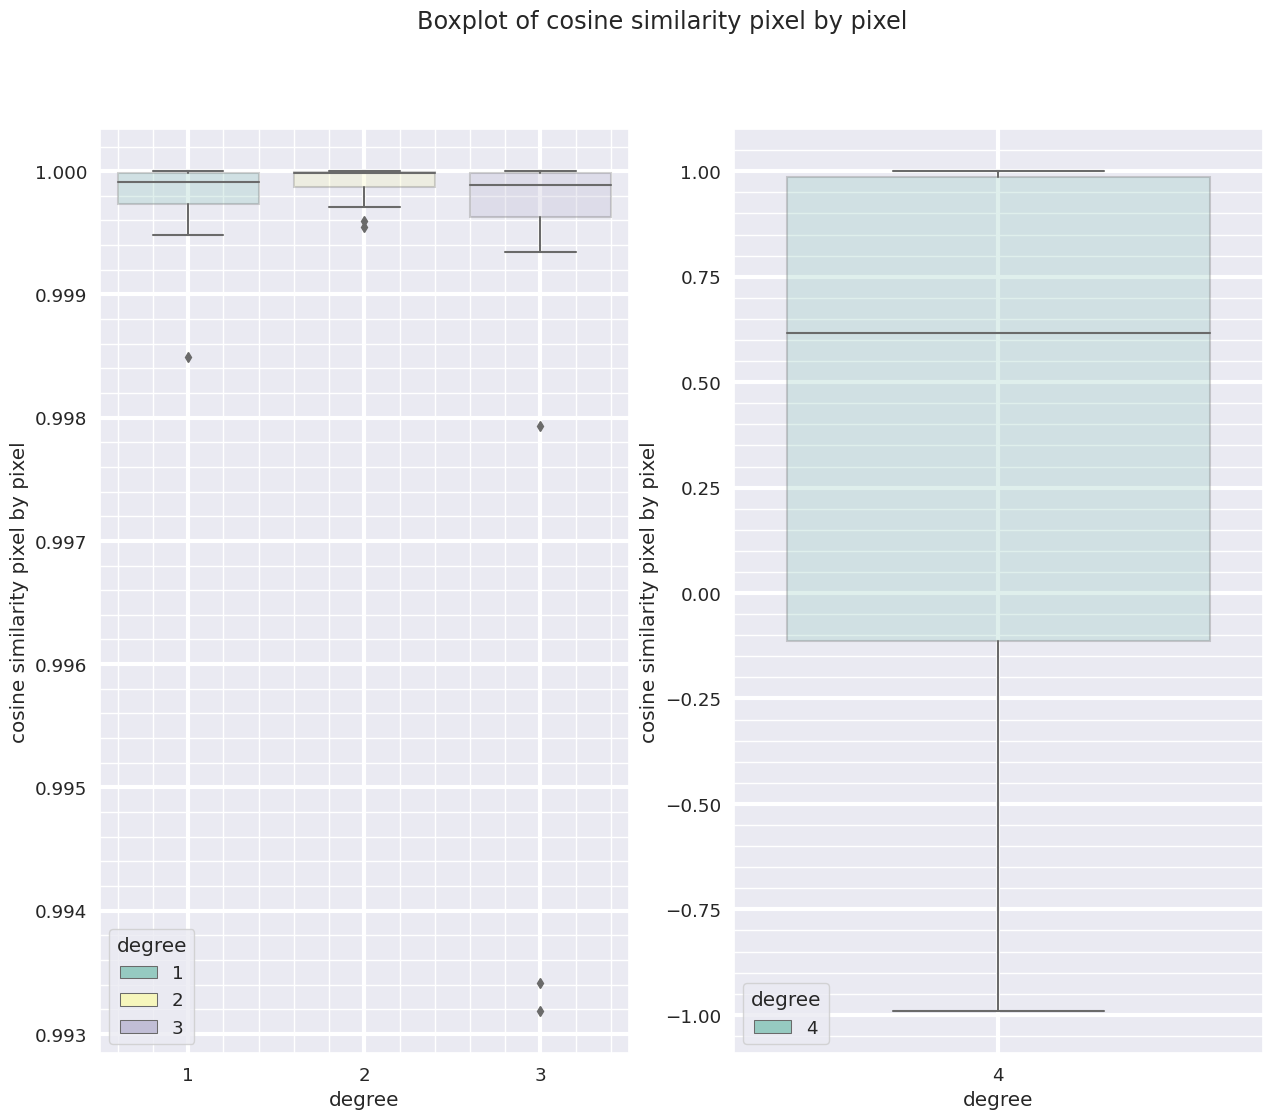

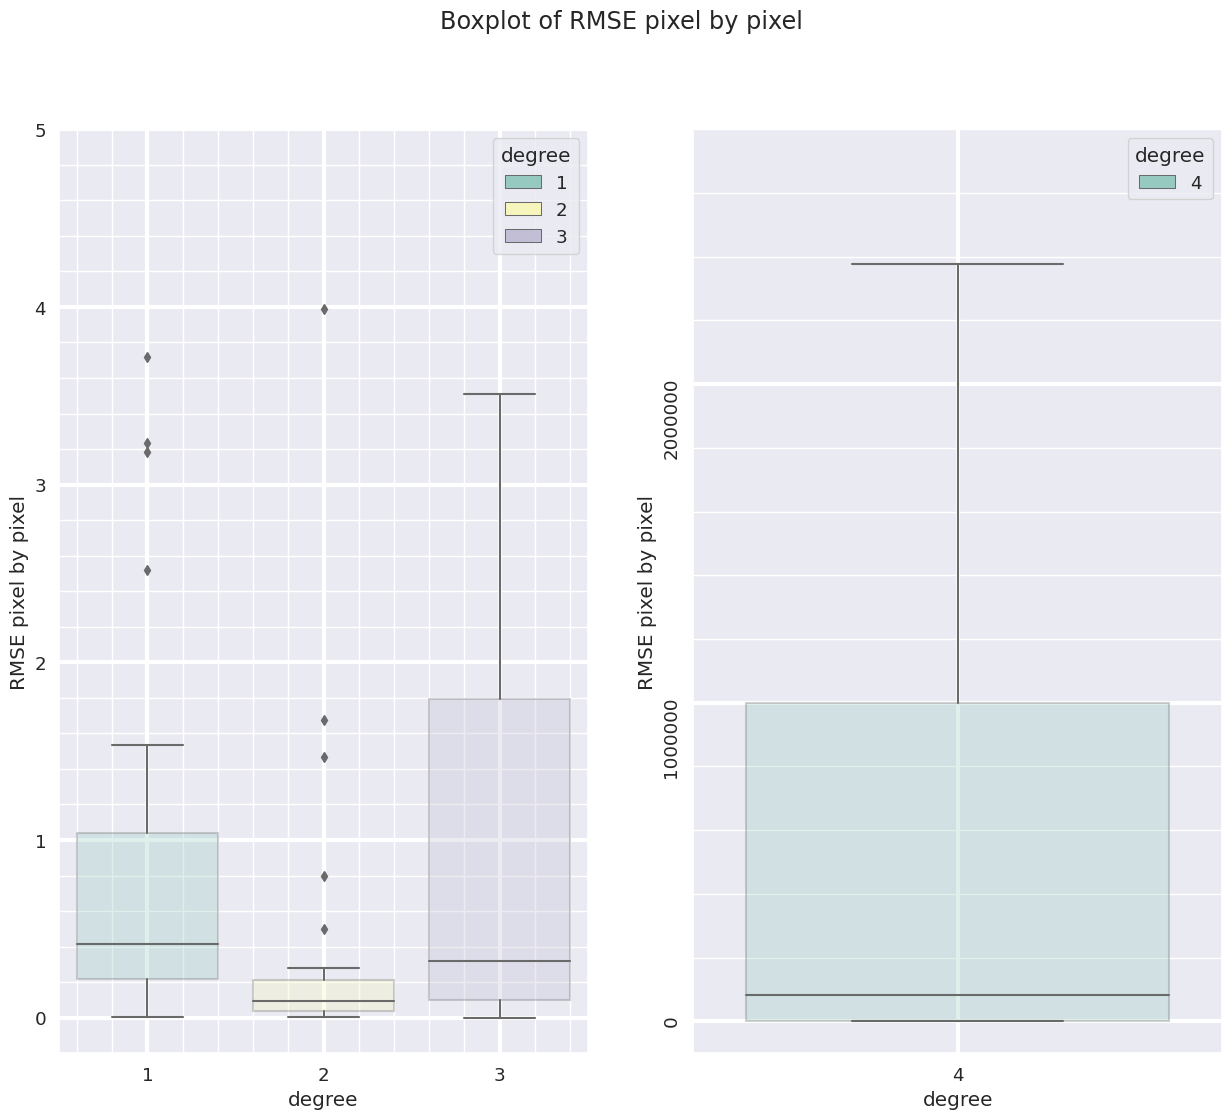

In [8]:
RPCC.fit_predict_visualise(X, y, rmse_ylims=((-0.2, 5), (-0.01e7, 0.28e7)))
None

# II. <u>Исследование работы алгоритма RPCC на гиперспектральных фотографиях из датасета Ли<u>

> ## 0. Функция обработки гиперспектрального изображения:
* **Обрабатывает спектры каждого пикселя**
* **Переводит спектры в XYZ** и сохраняет в Json для последующего чтения 
* **Переводит спектры в пространство камеры** и сохраняет в Json для последующего чтения
* **Возвращает** (h5_XYZ, h5_camera)
* **Отрисовывает картинку** по h5_XYZ.

In [9]:
def process_hyperspectral_image(filename:str, cmfs_cie, cmfs_camera, illuminant, save_pics=False):
    flag = 1 # need to read
    f = h5py.File(f'/home/yaroslav/progs/iitp/root_polynomial_color_correction/spectral_files/h5/{filename}.h5', 'r')
    df = f['img\\']
    try:
        with open(f'/home/yaroslav/progs/iitp/root_polynomial_color_correction/xyz_files/img_xyz_standard_observer_{filename}-h5.json', 'r') as openfile:
            load_json_xyz = json.load(openfile)
        with open(f'/home/yaroslav/progs/iitp/root_polynomial_color_correction/xyz_files/img_camera_{filename}-h5.json', 'r') as openfile:
            load_json_camera = json.load(openfile)
        flag = 0
    except:
        data = df[:,:,:]
        print("file-read-ok")
        shape = colour.SpectralShape(400, 730, 10)
        print("colour-preprocess-ok")
        reshaped_data = np.array([data[i,:,:].ravel() for i in range(df.shape[0])])
        msds = colour.MultiSpectralDistributions(reshaped_data, shape)
        print('colour-msds-ok')
        
        pixels_xyz = colour.msds_to_XYZ(msds, cmfs=cmfs_cie, illuminant=illuminant, method="Integration")
        pixels_xyz_list = pixels_xyz.tolist()
        print('pixels-xyz-list-ok')
        # Writing to json
        with open(f"/home/yaroslav/progs/iitp/root_polynomial_color_correction/xyz_files/img_xyz_standard_observer_{filename}-h5.json", "w") as outfile:
            json.dump(pixels_xyz_list, outfile)
        print('json-pixels-xyz-dump-ok')
        
        pixels_camera = colour.msds_to_XYZ(msds, cmfs=cmfs_camera, illuminant=illuminant, method="Integration")
        pixels_camera_list = pixels_camera.tolist()
        print('pixels-camera-list-ok')
        # Writing to json
        with open(f"/home/yaroslav/progs/iitp/root_polynomial_color_correction/xyz_files/img_camera_{filename}-h5.json", "w") as outfile:
            json.dump(pixels_camera_list, outfile)
        print('json-pixels-camera-dump-ok')

    if flag:
        # Reading from json file
        with open(f'/home/yaroslav/progs/iitp/root_polynomial_color_correction/xyz_files/img_xyz_standard_observer_{filename}-h5.json', 'r') as openfile:
            load_json_xyz = json.load(openfile)
        print('json-load-xyz-ok')
        with open(f'/home/yaroslav/progs/iitp/root_polynomial_color_correction/xyz_files/img_camera_{filename}-h5.json', 'r') as openfile:
            load_json_camera = json.load(openfile)
        print('json-load-camera-ok')
    loaded_xyz = np.array(load_json_xyz)
    loaded_camera = np.array(load_json_camera)
    print('writing-reading completed')
    
    if save_pics:
        xyz_img = loaded_xyz.reshape(df.shape[1], df.shape[2], 3)

        res = (xyz_img < 0).sum()
        print(f'xyz_values<0 - {res} elements')
        xyz_img[xyz_img < 0] = 0

        res = (xyz_img > 255).sum()
        print(f'xyz_values>255 - {res} elements')
        xyz_img[xyz_img > 255] = 255

        plt.imsave(f'/home/yaroslav/progs/iitp/root_polynomial_color_correction/gen_img/xyz-{filename}-h5.jpeg', xyz_img/255)
        print('saving ok')
    return (loaded_xyz, loaded_camera)

> # 1. Генерация гиперспектрального изображения в пространстве камеры и в пространстве XYZ
Обработанные файлы:
> * 2019-08-27_046.h5
> * 2019-09-18_003.h5

In [10]:
xyz_image1, camera_image1 = process_hyperspectral_image(filename='2019-08-27_046', cmfs_cie=cmfs_cie, 
                                                      cmfs_camera=cmfs_camera, illuminant=illuminant, save_pics=True)

writing-reading completed
xyz_values<0 - 0 elements
xyz_values>255 - 0 elements
saving ok


In [11]:
xyz_image2, camera_image2 = process_hyperspectral_image(filename='2019-09-18_003', cmfs_cie=cmfs_cie, 
                                                      cmfs_camera=cmfs_camera, illuminant=illuminant, save_pics=True)

writing-reading completed
xyz_values<0 - 0 elements
xyz_values>255 - 0 elements
saving ok


> ## 2. Применение модели к сгенерированному в пространстве камеры изображению  и расчет метрик
<!-- > предсказываем на том же, на чем учились, потому что просто делаем псевдообращение -->

**Тренировка RPCC 1-4 степеней на первой фотографии**

In [12]:
models = [RPCC(i+1) for i in range(4)]
[models[i].fit(X=camera_image1, y=xyz_image1) for i in range(4)]
None

**Расчет метрик для результата работы RPCC 1-4 степеней на первой фотографии**

In [13]:
data = [RPCC.get_cosine_rmse(y_pred=model.predict(camera_image1), y=xyz_image1) for model in models]
None

>> ### Cosine similarity, рассчитанная попиксельно

In [14]:
cosine_metrics_df = pd.concat([pd.DataFrame(data[i][0]) for i in range(4)], axis=1)
cosine_metrics_df.columns = [f'{i+1} degree' for i in range(4)]
cosine_metrics_df.describe()

,1 degree,2 degree,3 degree,4 degree
count,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.999891,0.999971,0.999988,0.999991
std,0.000309,0.000070,0.000040,0.000032
min,0.992851,0.994975,0.993246,0.997627
25%,0.999876,0.999950,0.999989,0.999994
50%,0.999953,0.999997,0.999998,0.999999
75%,0.999999,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


>> ### RMSE, рассчитанная попиксельно

In [15]:
rmse_metrics_df = pd.concat([pd.DataFrame(data[i][1]) for i in range(4)], axis=1)
rmse_metrics_df.columns = [f'{i+1} degree' for i in range(4)]
rmse_metrics_df.describe()

,1 degree,2 degree,3 degree,4 degree
count,2.621440e+05,2.621440e+05,2.621440e+05,2.621440e+05
mean,2.523230e-02,1.042140e-02,8.569041e-03,8.348089e-03
std,8.351441e-02,4.054162e-02,3.514297e-02,3.442208e-02
min,9.828847e-08,1.005095e-07,2.296631e-08,1.302793e-08
25%,1.235743e-03,2.007372e-04,8.776287e-05,7.063745e-05
50%,5.180826e-03,6.029656e-04,2.632522e-04,1.979947e-04
75%,1.643503e-02,2.715511e-03,1.803494e-03,1.847339e-03
max,2.263901e+00,1.370190e+00,1.730421e+00,1.223296e+00


>> ### Расчет метрик для результата работы модели 2 степени на 2 фотографии, обученной на 1 фотографии

In [18]:
sec_cos, sec_rmse = RPCC.get_cosine_rmse(y_pred=models[1].predict(camera_image2), y=xyz_image2)

In [19]:
sec_df = pd.concat([pd.DataFrame(sec_cos), pd.DataFrame(sec_rmse)], axis=1)
sec_df.columns = ['cosine similarity', 'RMSE']
sec_df.describe()

,cosine similarity,RMSE
count,262144.000000,262144.000000
mean,0.999555,2.506076
std,0.000816,6.603285
min,0.993359,0.000054
25%,0.999404,0.080128
50%,0.999954,0.146258
75%,0.999991,0.488581
max,1.000000,56.504760


RMSE **увеличилась**, cosine similarity **осталась примерно такой же**

> # Визуализация работы алгоритма

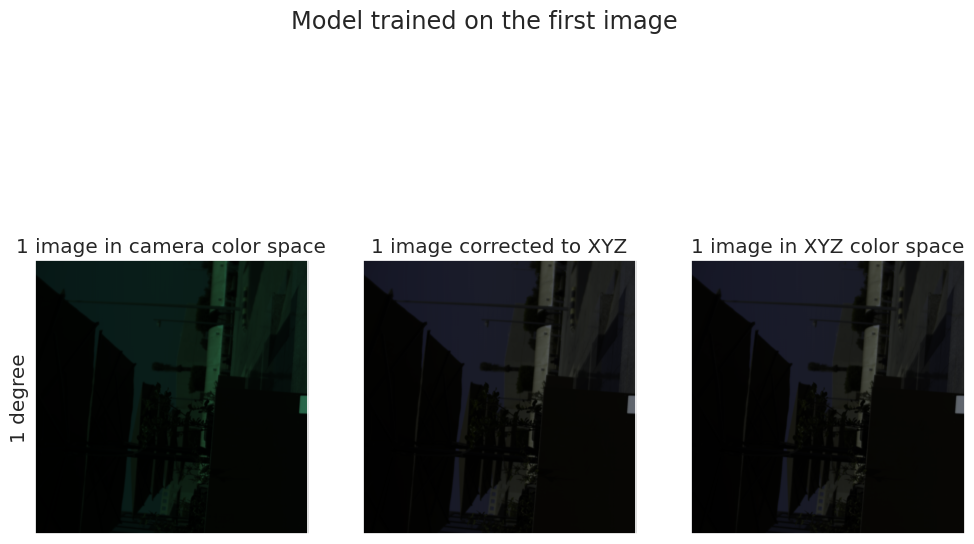

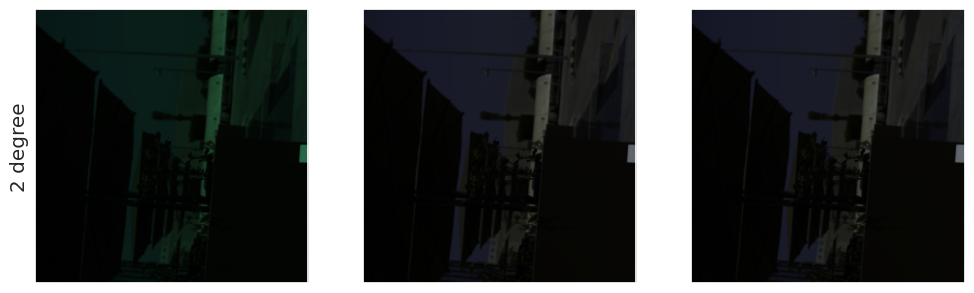

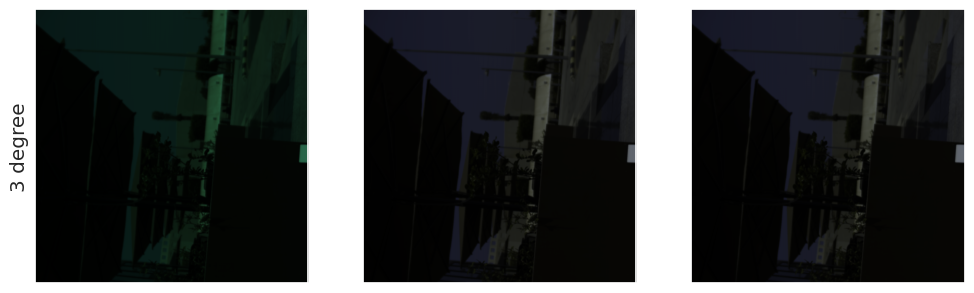

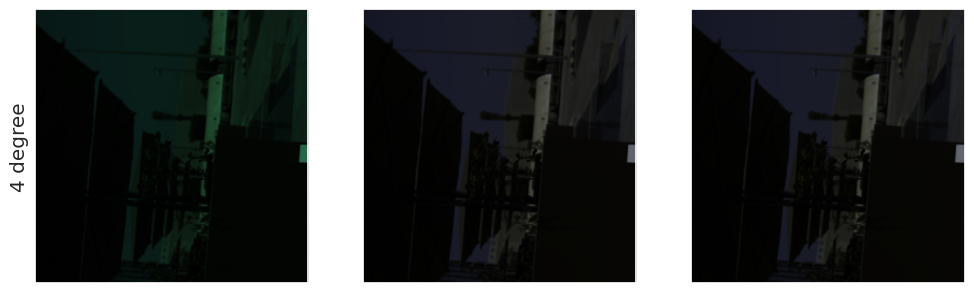

In [20]:
for i in range(4):
    fig = plt.figure(figsize=(12, 8))
    if not i:
        fig.suptitle('Model trained on the first image')
    ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
    model = RPCC(i+1)
    model.fit(X=camera_image1, y=xyz_image1)
    for j in range(3):
        ax[j].grid(False)
        ax[j].set_xticks([])
        ax[j].set_yticks([])

        if j==0:
            ax[j].imshow(camera_image1.reshape(512, 512, 3)/255)
            ax[j].set_ylabel(f"{i+1} degree")
            if not i:
                ax[j].set_title('1 image in camera color space')
        elif j==1:
            ax[j].imshow(model.predict(camera_image1).reshape(512, 512, 3)/255)
            if not i:
                ax[j].set_title('1 image corrected to XYZ')

        else:
            ax[j].imshow(xyz_image1.reshape(512, 512, 3)/255)
            if not i:
                ax[j].set_title('1 image in XYZ color space')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


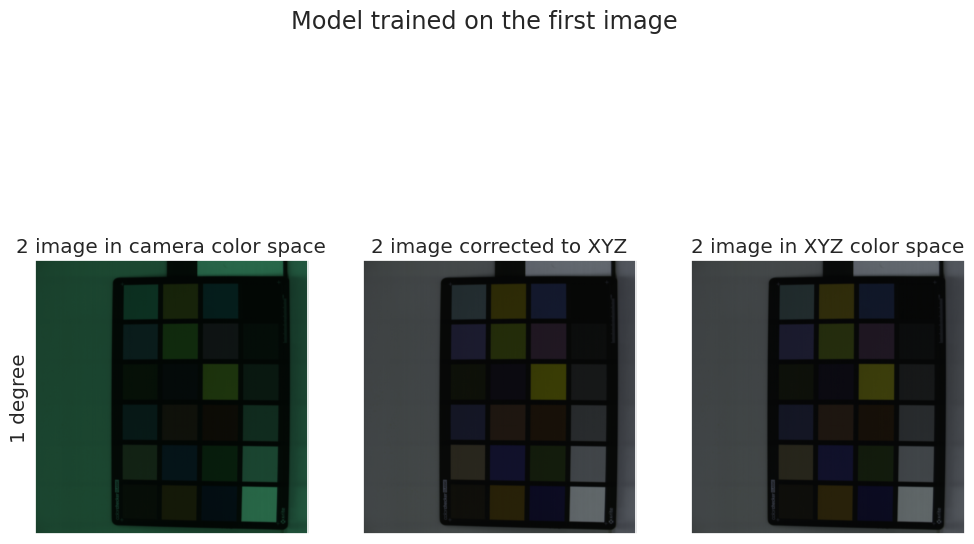

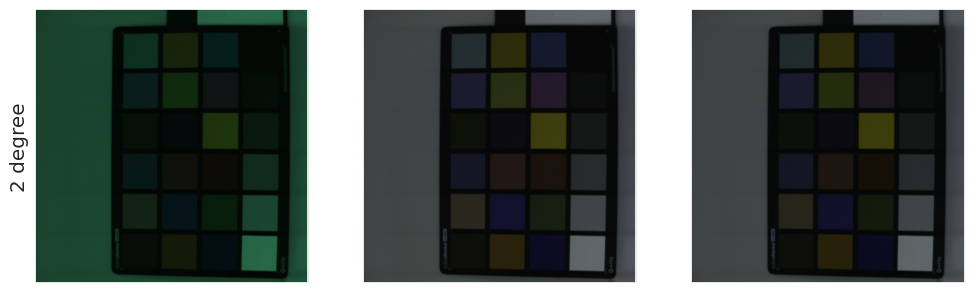

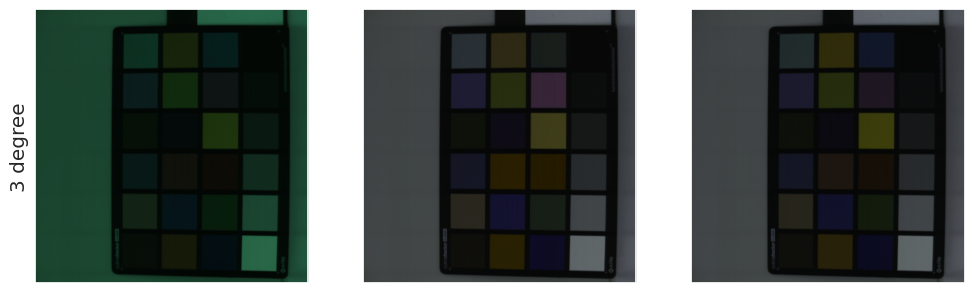

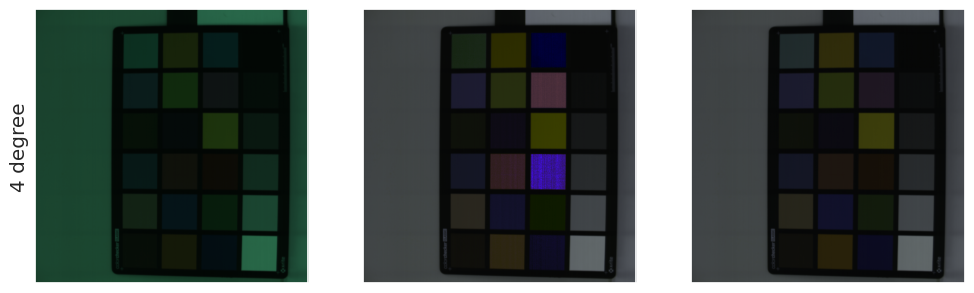

In [21]:
for i in range(4):
    fig = plt.figure(figsize=(12, 8))
    if not i:
        fig.suptitle('Model trained on the first image')
    ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
    model = RPCC(i+1)
    model.fit(X=camera_image1, y=xyz_image1)
    for j in range(3):
        ax[j].grid(False)
        ax[j].set_xticks([])
        ax[j].set_yticks([])

        if j==0:
            ax[j].imshow(camera_image2.reshape(512, 512, 3)/255)
            ax[j].set_ylabel(f"{i+1} degree")
            if not i:
                ax[j].set_title('2 image in camera color space')
        elif j==1:
            ax[j].imshow(model.predict(camera_image2).reshape(512, 512, 3)/255)
            if not i:
                ax[j].set_title('2 image corrected to XYZ')

        else:
            ax[j].imshow(xyz_image2.reshape(512, 512, 3)/255)
            if not i:
                ax[j].set_title('2 image in XYZ color space')